In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard

TensorFlow 2.x selected.


In [0]:
# pwd

from IPython.display import Image

'/content'

In [0]:
import tensorflow as tf
import datetime, os,time
import numpy as np

### Adam: A Method for Stochastic Optimization


*   It is an adaptive learning rate method i.e. it computes individual learning rates for different parameters 
*  Adam uses estimations of first and second moments of gradient to adapt the learning rate for each weight of the neural network.



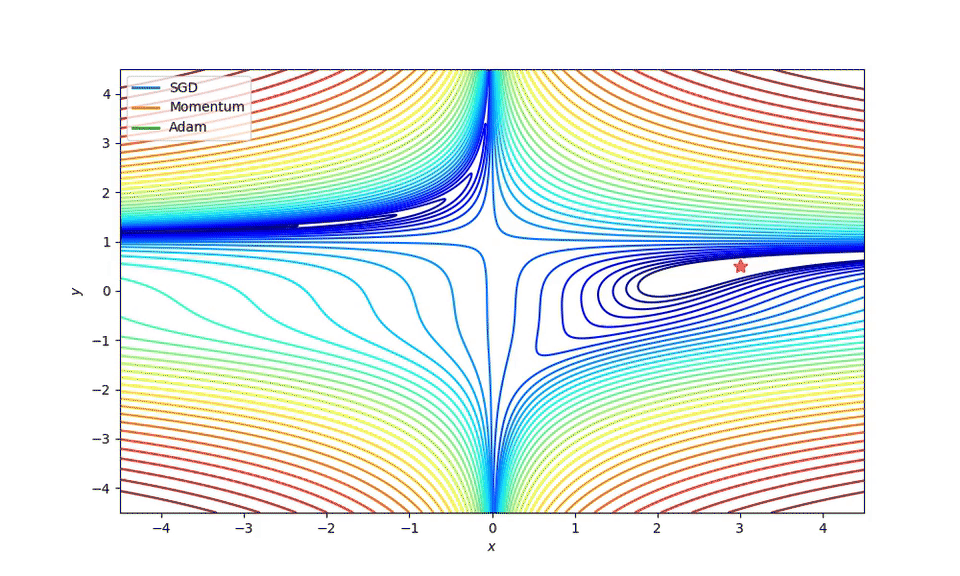

In [0]:
# Image('adamFormulae/adam.gif')
with open('adamFormulae/adam.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

### Algorithm


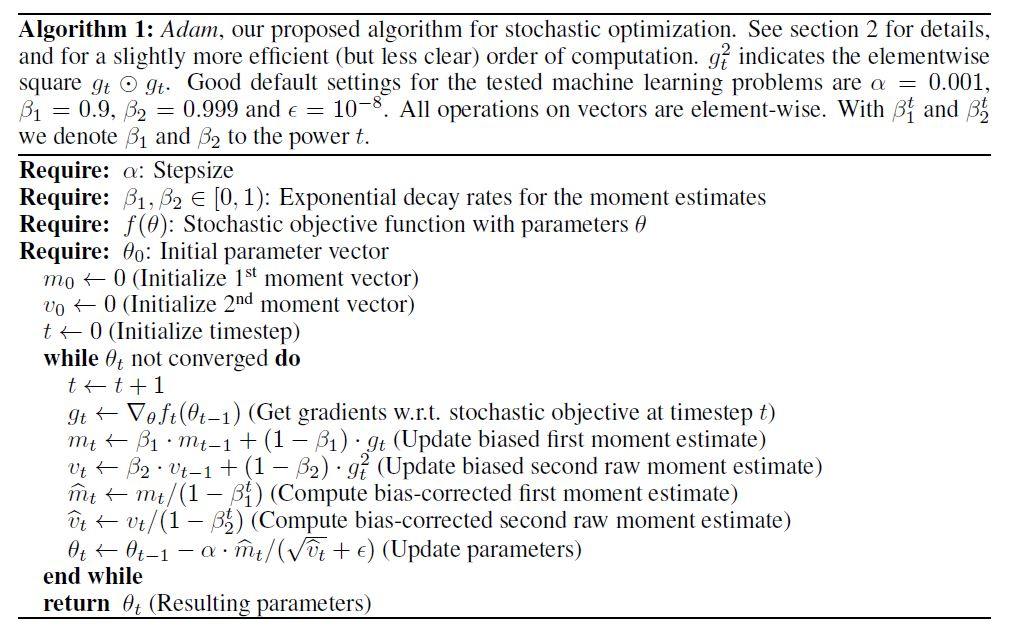

In [0]:
Image('adamFormulae/Algorithm.jpg')

### Explanation

* The gradient of the cost function of neural network can be considered a random variable, since it usually evaluated on some small random batch of data. 
 * The first moment is the mean <br>
 * The second moment is the uncentered variance<br> 

* Adam uses exponentially moving averages computed on gradients evaluated on a current mini-batch:


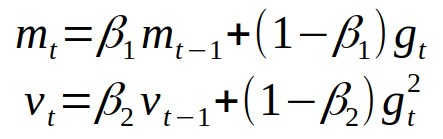

In [0]:
Image('adamFormulae/equation_2_3.jpg')




Where 
* m and v are moving averages of gradient and squared gradient
* g is gradient on current mini-batch
* betas — hyper-parameters of the algorithm. 
  * They have really good default values of 0.9 and 0.999 respectively. <br> 
  * Almost no one ever changes these values<br> 

* The vectors of moving averages are initialized with zeros at the first iteration.

## Property to ensure the estimators are unbaised
* Ideally, inorder to ensure unbaised estimators for m and v. 
* Expected values of the estimators should equal the parameter we’re trying to estimate. That is:




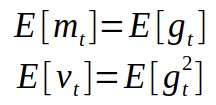

In [0]:
Image('adamFormulae/equation_4_5.jpg')

## Are the estimates for $m$ and $v$ unbaised? 
* The above conditions do not hold true for the moving averages because we initialize averages with zeros, the estimators are biased towards zero.
* To prove this we need to formula for m to the very first gradient. We unroll a couple values of m to see he pattern we’re going to use:


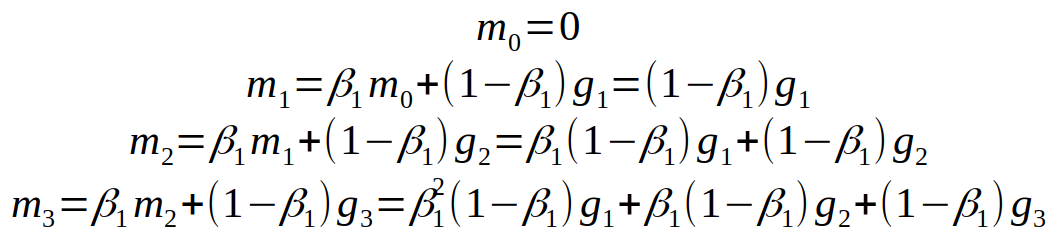

In [0]:
Image('adamFormulae/equation_6.png')

* The more we expand the value of m, the less first values of gradients contribute to the overall value, as they get multiplied by smaller and smaller beta. 
* Capturing this pattern, we can rewrite the formula for our moving average:

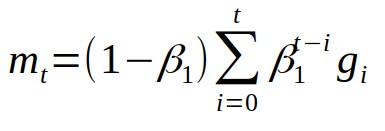

In [0]:
Image('adamFormulae/equation_7.jpg')

## BIAS Correction

* We correct for the discrepancy of the two by examining how the expected value of m relates to the true first moment




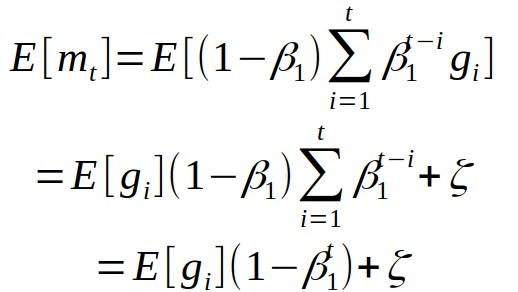

In [0]:
Image('adamFormulae/equation_8.jpg')

There are two things we should note from that equation.
1.	We have biased estimator. This is not just true for Adam only, the same holds for algorithms, using moving averages (SGD with momentum, RMSprop, etc.).
2.	It won’t have much effect unless it’s the beginning of the training, because the value beta to the power of t is quickly going towards zero.

Now we need to correct the estimator, so that the expected value is the one we want



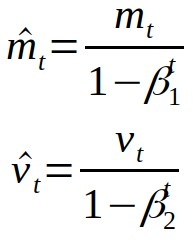

In [0]:
Image('adamFormulae/equation_9.jpg')


## Finally weight update
* use those moving averages to scale learning rate individually for each parameter. 
* The weight update in adam is done as follows:


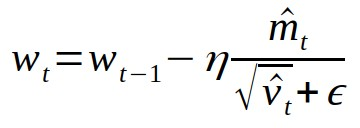

In [0]:
Image('adamFormulae/equation_10.jpg')


Where 
* w is model weights
* $eta$ is the step size 
<br>

Notes
* Intiuition is decay the learning rate for the parameters in proportion to thier update history(i.e the denominator) 
* so for dense features the learning rate will decrease
* Does everything that RMPProp does to solve the decay problem of Adagrad
* It also uses cumulative history of gradients i.e instead of just delta wt it is using mt


### Properties of Adam
1.	Step size of Adam update rule is invariant to the magnitude of the gradient, which helps a lot when going through areas with tiny gradients (such as saddle points or ravines). In these areas SGD struggles to quickly navigate through them.
2.	Adam was designed to combine the advantages of Adagrad, which works well with sparse gradients, and RMSprop, which works well in on-line settings. Having both of these enables us to use Adam for broader range of tasks. Adam can also be looked at as the combination of RMSprop and SGD with momentum.


## Experiments 

In [0]:
IMG_ROWS, IMG_COLS = 28, 28
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 1)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train/255.0
X_test = X_test/255.0

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) train samples
(10000, 28, 28, 1) test samples


In [0]:
# def create_model():
#   return tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape=(28, 28)),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(10, activation='softmax')
#   ])

def create_model():
    return tf.keras.models.Sequential([ tf.keras.layers.Conv2D(32, (3, 3),activation = 'relu'),
                                     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), tf.keras.layers.Flatten(input_shape=(28, 28)),
                                     tf.keras.layers.Dense(512, activation='relu'),tf.keras.layers.Dropout(0.2),
                                     tf.keras.layers.Dense(10, activation='softmax')])

In [0]:

def create_model(batch_size, epochs, lr, beta1, beta2):
    NAME = "{}-lr-{}-beta1-{}-beta2-{}".format(lr, beta1, beta2, int(time.time()))
    print(NAME)
    model =tf.keras.models.Sequential([ tf.keras.layers.Conv2D(32, (3, 3),activation = 'relu'),
                                        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                        tf.keras.layers.Conv2D(64, (3, 3),activation = 'relu'),
                                        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
                                        tf.keras.layers.Flatten(input_shape=(28, 28)),
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(10, activation='softmax')])
    
    optimizer = tf.keras.optimizers.Adam(lr=lr, beta_1=beta1, beta_2=beta2, amsgrad=False)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # model.summary()
    logdir = os.path.join("adam_parameter_tuning/{}".format(NAME))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    model.fit(x=X_train, y=y_train,batch_size=batch_size, epochs=5, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])
    score = model.evaluate(X_test, y_test, verbose=1)
    print("Test score:", score[0])
    print('Test accuracy:', score[1])
    # tensorboard = TensorBoard()

In [0]:

batch_size=128
epochs=5
# validation_split=0.3
# classes = 10
for lr in [0.01, 0.001, 0.0001]:
  for beta1 in [0.5, 0.9]:
    for beta2 in [0.5, 0.999]:
      create_model(batch_size, epochs, lr, beta1, beta2)

0.01-lr-0.5-beta1-0.5-beta2-1582131139
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 50s 840us/sample - loss: 0.1428 - accuracy: 0.9572 - val_loss: 0.0674 - val_accuracy: 0.9819
Epoch 2/5
60000/60000 [==============================] - 49s 819us/sample - loss: 0.0861 - accuracy: 0.9771 - val_loss: 0.1011 - val_accuracy: 0.9819
Epoch 3/5
60000/60000 [==============================] - 49s 822us/sample - loss: 0.0934 - accuracy: 0.9776 - val_loss: 0.1235 - val_accuracy: 0.9764
Epoch 4/5
60000/60000 [==============================] - 49s 822us/sample - loss: 0.1049 - accuracy: 0.9770 - val_loss: 0.0747 - val_accuracy: 0.9834
Epoch 5/5
10000/10000 [==============================] - 4s 355us/sample - loss: 0.0904 - accuracy: 0.9835
Test score: 0.0904055370272938
Test accuracy: 0.9835
0.01-lr-0.5-beta1-0.999-beta2-1582131391
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 50s

In [1]:
%tensorboard --logdir adam_parameter_tuning

UsageError: Line magic function `%tensorboard` not found.


In [0]:

def create_model_opt(optimizer):
    NAME = "{}-optimizer-{}".format(optimizer, beta1, beta2, int(time.time()))
    print(NAME)
    model = tf.keras.models.Sequential([ tf.keras.layers.Conv2D(32, (3, 3),activation = 'relu'),
                                        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                        tf.keras.layers.Conv2D(64, (3, 3),activation = 'relu'),
                                        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
                                        tf.keras.layers.Flatten(input_shape=(28, 28)),
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(10, activation='softmax')])
    
    # optimizer = tf.keras.optimizers.Adam(lr=lr, beta_1=beta1, beta_2=beta2, amsgrad=False)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # model.summary()
    logdir = os.path.join("all_optimizer/{}".format(NAME))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    model.fit(x=X_train, y=y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])
    score = model.evaluate(X_test, y_test, verbose=1)
    print("Test score:", score[0])
    print('Test accuracy:', score[1])
    # tensorboard = TensorBoard()

In [0]:
optimizers = ['Adadelta', 'Adagrad', 'Adam', 'Adamax', 'Nadam', 'RMSprop', 'SGD']

for optimizer in optimizers:
    create_model_opt(optimizer)
    # model = Sequential()
    # model.add(Conv2D(16, (3,3), activation='relu', input_shape=X_train[0].shape))
    # model.add(MaxPooling2D())
    # model.add(Conv2D(16, (3,3), activation='relu'))
    # model.add(MaxPooling2D())
    # model.add(Flatten())
    # model.add(Dense(10, activation='softmax'))
    # model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['categorical_accuracy'])
    # tensorboard = TensorBoard(os.path.join('log_test4',f'{optimizer}_{time.time()}'))
    # model.fit(X_train, y_train, batch_size=32, epochs=5, callbacks=[tensorboard])

Adadelta-optimizer-0.9
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 53s 880us/sample - loss: 2.2819 - accuracy: 0.1410 - val_loss: 2.2612 - val_accuracy: 0.2379
Epoch 2/5
60000/60000 [==============================] - 53s 876us/sample - loss: 2.2462 - accuracy: 0.2549 - val_loss: 2.2242 - val_accuracy: 0.3968
Epoch 3/5
60000/60000 [==============================] - 53s 878us/sample - loss: 2.2094 - accuracy: 0.3694 - val_loss: 2.1849 - val_accuracy: 0.5118
Epoch 4/5
60000/60000 [==============================] - 53s 877us/sample - loss: 2.1682 - accuracy: 0.4512 - val_loss: 2.1405 - val_accuracy: 0.5734
Epoch 5/5
10000/10000 [==============================] - 4s 370us/sample - loss: 2.0887 - accuracy: 0.6100
Test score: 2.0886669815063477
Test accuracy: 0.61
Adagrad-optimizer-0.9
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 53s 891us/sample - loss: 0.4483 - accura

In [2]:
%tensorboard --logdir all_optimizer

UsageError: Line magic function `%tensorboard` not found.


In [0]:
IMG_ROWS, IMG_COLS = 28, 28
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 1)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train/255.0
X_test = X_test/255.0

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1) train samples
(10000, 28, 28, 1) test samples


In [0]:
def create_model_opt(optimizer):
    NAME = "{}-optimizer-{}".format(optimizer, int(time.time()))
    print(NAME)
    model = tf.keras.models.Sequential([ tf.keras.layers.Conv2D(32, (3, 3),activation = 'relu'),
                                        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                        tf.keras.layers.Conv2D(64, (3, 3),activation = 'relu'),
                                        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
                                        tf.keras.layers.Flatten(input_shape=(28, 28)),
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(10, activation='softmax')])
    
    # optimizer = tf.keras.optimizers.Adam(lr=lr, beta_1=beta1, beta_2=beta2, amsgrad=False)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # model.summary()
    logdir = os.path.join("all_optimizer_fashionMNIST/{}".format(NAME))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    model.fit(x=X_train, y=y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])
    score = model.evaluate(X_test, y_test, verbose=1)
    print("Test score:", score[0])
    print('Test accuracy:', score[1])
    # tensorboard = TensorBoard()

In [0]:
optimizers = ['Adadelta', 'Adagrad', 'Adam', 'Adamax', 'Nadam', 'RMSprop', 'SGD']

for optimizer in optimizers:
    create_model_opt(optimizer)

Adadelta-optimizer-1582136571
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 55s 911us/sample - loss: 2.2767 - accuracy: 0.1322 - val_loss: 2.2472 - val_accuracy: 0.2135
Epoch 2/5
60000/60000 [==============================] - 54s 895us/sample - loss: 2.2228 - accuracy: 0.2335 - val_loss: 2.1933 - val_accuracy: 0.3650
Epoch 3/5
60000/60000 [==============================] - 54s 894us/sample - loss: 2.1672 - accuracy: 0.3278 - val_loss: 2.1339 - val_accuracy: 0.4405
Epoch 4/5
60000/60000 [==============================] - 54s 900us/sample - loss: 2.1031 - accuracy: 0.3799 - val_loss: 2.0640 - val_accuracy: 0.4622
Epoch 5/5
10000/10000 [==============================] - 4s 424us/sample - loss: 1.9807 - accuracy: 0.4896
Test score: 1.9806525421142578
Test accuracy: 0.4896
Adagrad-optimizer-1582136845
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 55s 917us/sample - loss:

In [3]:
%tensorboard --logdir all_optimizer_fashionMNIST

UsageError: Line magic function `%tensorboard` not found.


In [0]:
pwd

'/content'